# 策略梯度算法

教程链接：[策略梯度算法](https://hrl.boyuai.com/chapter/2/%E7%AD%96%E7%95%A5%E6%A2%AF%E5%BA%A6%E7%AE%97%E6%B3%95)

基于值函数的方法主要是学习值函数，然后根据值函数导出一个策略，学习过程中并不存在一个显式的策略；而基于策略的方法则是直接显式地学习一个目标策略。

基于策略的方法首先需要将策略参数化。我们可以用一个线性模型或者神经网络模型来为这样一个策略函数建模，输入某个状态，然后输出一个动作的概率分布。我们的目标是要寻找一个最优策略并最大化这个策略在环境中的期望回报。

策略梯度算法为在线策略（on-policy）算法，即必须使用当前策略采样得到的数据来计算梯度。在每一个状态下，梯度的修改是让策略更多地去采样到*带来较高Q值的动作*，更少地去采样到带来较低Q值的动作。

## 1. REINFORCE算法

REINFORCE 算法是策略梯度乃至强化学习的典型代表，智能体根据当前策略直接和环境交互，通过采样得到的轨迹数据直接计算出策略参数的梯度，进而更新当前策略，使其向最大化策略期望回报的目标靠近。

这种学习方式是典型的从交互中学习，并且其优化的目标（即策略期望回报）正是最终所使用策略的性能，这比基于价值的强化学习算法的优化目标（一般是时序差分误差的最小化）要更加直接。

REINFORCE 算法理论上是能保证局部最优的，它实际上是借助蒙特卡洛方法采样轨迹来估计动作价值，这种做法的一大优点是可以得到无偏的梯度。但是，正是因为使用了蒙特卡洛方法，REINFORCE 算法的梯度估计的方差很大，可能会造成一定程度上的不稳定，这也是 Actor-Critic 算法要解决的问题。

在计算策略梯度的公式中，我们需要用到Q值函数，可以用多种方式对它进行估计，REINFORCE 算法便是采用了蒙特卡洛方法来估计Q值函数。

In [5]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [6]:
class PolicyNet(nn.Module):
    """
    定义策略网络，其输入是某个状态，输出则是该状态下的动作概率分布。
    """
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        这里采用在离散动作空间上的 softmax() 函数来实现一个可学习的多项分布(multinomial distribution)。
        """
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [7]:
class REINFORCE:
    """
    REINFORCE 算法
    """
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, 
            learning_rate:float, gamma:float, 
            device:torch.device
        ):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state:np.ndarray) -> int:
        """根据动作概率分布随机采样"""
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict:dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor(np.array([state_list[i]]), dtype=torch.float).to(self.device)
            action = torch.tensor(np.array([action_list[i]])).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降

In [8]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s, episode=1000, return=182.000]


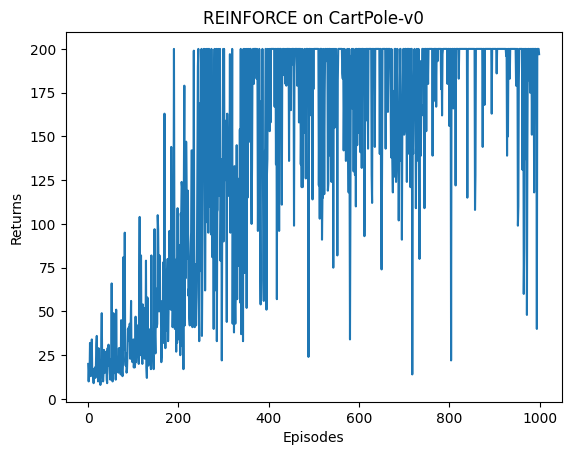

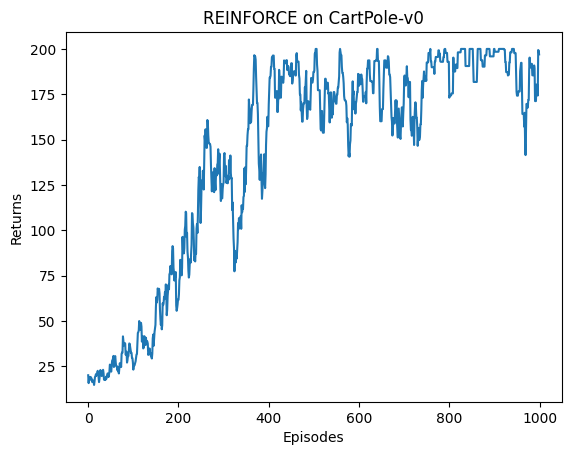

In [9]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

可以看到，随着收集到的轨迹越来越多，REINFORCE 算法有效地学习到了最优策略。不过，相比于前面的 DQN 算法，REINFORCE 算法使用了更多的序列，这是因为 REINFORCE 算法是一个在线策略算法，之前收集到的轨迹数据不会被再次利用。此外，REINFORCE 算法的性能也有一定程度的波动，这主要是因为每条采样轨迹的回报值波动比较大，这也是 REINFORCE 算法主要的不足。